# Outlier Detection

In [1]:
from features_preprocess_pipeline import *
import itertools
import numpy as np
import pandas as pd
from skimage.feature import local_binary_pattern, hog
import matplotlib.pyplot as plt
import matplotlib as mpl
from src.third_party import GLCM
from scipy.stats import ttest_ind
from lpproj import LocalityPreservingProjection 
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_curve, auc
from src.models.util import report_performance
from sklearn.model_selection import train_test_split
from src.models.dataload import load_data
from pathlib import Path
from time import time
from datetime import datetime
from scipy import special
from sklearn import manifold
from scipy import stats
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print
from pyod.models.combination import aom, moa, average, maximization

Using TensorFlow backend.


In [2]:
# Load birads data from intrim
interim_data = pd.read_csv(Path(pf.INTERM_DIR) / pf.INTERM_DATA, index_col = 0)
interim_data.set_index('internal_ID', inplace=True)
positive_ids = interim_data[(interim_data['BIRADS'] > 3) & 
                            (interim_data['BIRADS'] != 0)].index.tolist()
negative_ids = interim_data[(interim_data['BIRADS'] <= 3) & 
                            (interim_data['BIRADS'] != 0)].index.tolist()

ID_list = positive_ids +negative_ids

In [3]:
# Load training parameters
input_filepath = Path(pf.AGGREG_DIR)
intrain = (1,2,3,4,5,6)
train_neg_excl = params.TRAIN_NEG_EXCL
train_pos_excl = params.TRAIN_POS_EXCL
intest = (1,2,3,4,5,6)
test_pos_excl = params.TEST_NEG_EXCL
test_neg_excl = params.TEST_POS_EXCL
less_features = False

# Agregate feature parameters
selec_train=(intrain,
             train_neg_excl,
             train_pos_excl,
             intest,test_pos_excl,
             test_neg_excl)

# Load feature data
train_data, test_data, excluded_data, no_birads_data, _ = load_data(input_filepath,
                                                                    selec_train=selec_train,
                                                                    less_features=less_features,
                                                                    standardize=False)

# Separate feature data, labels and pids
X, y, pids = train_data
X_test, y_test, pids_test = test_data
X_blind, y_blind, pids_blind = no_birads_data
y_blind = np.array([2 for i in range(len(X_blind))])

In [4]:
# Normalize feature data
def normalize(train, test=[]):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    std = np.where(std != 0, std, 1)
    
    train = (train - mean)/std
    train = np.nan_to_num(train)
    if  len(test)==0:
        return train
    else:
        test = (test-mean)/std
        test = np.nan_to_num(test)
        return train, test
    
# Stack pids data and get logical queries by center
X_full = np.vstack([X, X_blind, X_test])
y_full = np.hstack([y, y_blind, y_test])

X_train_full = np.vstack([X, X_blind])
y_train_full = np.hstack([y, y_blind])

X_test_full = np.vstack([X, X_test])
y_test_full = np.hstack([y, y_test])

In [5]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF

## Analyze classifiers

In [6]:
# Approximate the fraction of positive samples
outliers_fraction = len(positive_ids)/len(ID_list)
print('Fraction of outliers: ', outliers_fraction)
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)': ABOD(contamination=outliers_fraction),
        'Feature Bagging':FeatureBagging(LOF(n_neighbors=35),contamination=outliers_fraction,check_estimator=False),
        'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=outliers_fraction),
        'Isolation Forest': IForest(contamination=outliers_fraction),
        'K Nearest Neighbors (KNN)': KNN(contamination=outliers_fraction),
        'Average KNN': KNN(method='mean',contamination=outliers_fraction),
        'Cluster-based Local Outlier Factor (CBLOF)':CBLOF(contamination=outliers_fraction,check_estimator=False,n_clusters=10),
        'Feature Bagging_50': FeatureBagging(base_estimator=None,
                                            n_estimators=50, contamination=outliers_fraction, max_features=1.0,
                                            bootstrap_features=True,
                                            check_detector=True,
                                            check_estimator=True, n_jobs=1,
                                            random_state=None, combination='max', verbose=0, estimator_params=None)
}

Fraction of outliers:  0.0430786904078116


In [7]:
def get_preds(X_train, X_test, y_test, classifiers):
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        
        clf.fit(normalize(X_train))

        train_score = clf.decision_scores_
        test_score = clf.decision_function(normalize(X_test))
        evaluate_print(clf_name, y_test, test_score)
        

In [8]:
# Evaluate different methods
get_preds(X, X_test, y_test, classifiers)

Angle-based Outlier Detector (ABOD) ROC:0.5613, precision @ rank n:0.1163
Feature Bagging ROC:0.5681, precision @ rank n:0.1163
Histogram-base Outlier Detection (HBOS) ROC:0.5095, precision @ rank n:0.1163
Isolation Forest ROC:0.526, precision @ rank n:0.0465
K Nearest Neighbors (KNN) ROC:0.5705, precision @ rank n:0.1395
Average KNN ROC:0.574, precision @ rank n:0.1163
Cluster-based Local Outlier Factor (CBLOF) ROC:0.537, precision @ rank n:0.093
Feature Bagging_50 ROC:0.5947, precision @ rank n:0.1163


Outlier detection often suffers from model instability due to its unsupervised nature. Thus, it is recommended to
combine various detector outputs, e.g., by averaging, to improve its robustness. Detector combination is a subfield of outlier ensembles. The PyOD library has built-in methods for combining different classifiers.

In [9]:
# Combine different methods
n_clf = 20  # number of base detectors

# Try different variations of best performing classifier along with other classifiers
k_list = [10,30,60,90,100,120,150,160,180,210,240,270]

train_scores = np.zeros([X.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

print('Initializing {n_clf} detectors'.format(n_clf=n_clf))

for i in range(12):
    k = k_list[i]
    # Get predictions with different n_estimators
    clf = FeatureBagging(base_estimator=None,
                        n_estimators=k, contamination=outliers_fraction, max_features=1.0,
                        bootstrap_features=True,
                        check_detector=True,
                        check_estimator=True, n_jobs=1,
                        random_state=None, combination='max', verbose=0, estimator_params=None)
    clf.fit(normalize(X))

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(normalize(X, X_test)[1])
    print('Base detector %i is fitted for prediction' % (i+1))

# Also add other classifiers
for i, (clf_name, clf) in enumerate(classifiers.items()):
    i+=12
    clf.fit(normalize(X))

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(normalize(X, X_test)[1])
    print('Base detector %i is fitted for prediction' % (i+1))

Initializing 20 detectors
Base detector 1 is fitted for prediction
Base detector 2 is fitted for prediction
Base detector 3 is fitted for prediction
Base detector 4 is fitted for prediction
Base detector 5 is fitted for prediction
Base detector 6 is fitted for prediction
Base detector 7 is fitted for prediction
Base detector 8 is fitted for prediction
Base detector 9 is fitted for prediction
Base detector 10 is fitted for prediction
Base detector 11 is fitted for prediction
Base detector 12 is fitted for prediction
Base detector 13 is fitted for prediction
Base detector 14 is fitted for prediction
Base detector 15 is fitted for prediction
Base detector 16 is fitted for prediction
Base detector 17 is fitted for prediction
Base detector 18 is fitted for prediction
Base detector 19 is fitted for prediction
Base detector 20 is fitted for prediction


In [10]:
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                   test_scores)

# Predicted scores from all base detectors on the test data is 
# stored in train_scores_norm and test_scores_norm
print('Decision score matrix on training data', train_scores_norm.shape)
print('Decision score matrix on test data', test_scores_norm.shape)

Decision score matrix on training data (1157, 20)
Decision score matrix on test data (584, 20)


In [11]:
# Combine and evaluate the combination result

# Combination by average
y_by_average = average(test_scores_norm)
evaluate_print('Combination by Average', y_test, y_by_average)

# Combination by max
y_by_maximization = maximization(test_scores_norm)
evaluate_print('Combination by Maximization', y_test, y_by_maximization)

# Combination by aom
y_by_aom = aom(test_scores_norm, n_buckets=4)
evaluate_print('Combination by AOM', y_test, y_by_aom)

# Combination by moa
y_by_moa = moa(test_scores_norm, n_buckets=4)
evaluate_print('Combination by MOA', y_test, y_by_moa)

Combination by Average ROC:0.5932, precision @ rank n:0.093
Combination by Maximization ROC:0.5595, precision @ rank n:0.1163
Combination by AOM ROC:0.5896, precision @ rank n:0.1163
Combination by MOA ROC:0.591, precision @ rank n:0.093


In [12]:
# Get train scores as well
y_by_average_train = average(train_scores_norm)

In [13]:
def performance(X, y, X_test, y_test, detailed = False, title=''):
    
    """ Obtain tuned LogReg model classification performance.
    

    Inputs
    ----------
    X: dataframe or numpy array
         training set with features
    y: np.array
         training targets    
    X_test: dataframe or numpy array
         test set with features
    y_test: np.array
         test targets    

    detailed: bool
         Indicates whether to print a detailed
         report and ROC curve or not
    title: str
         A title that is given to the ROC
         curve plot and the AUC score
        

    Returns
    -------
    AUC score for a specific technique
    Optional
    """
    clf = LogReg.model
    # Make sure I dont use pre-tuned model for feature evaluation
#     print('Tuned parameters: ', clf.get_params())
    clf.fit(X, y)
    probs = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs)
#     print("AUC score: " + title, auc(fpr,tpr))
    if detailed: 
        plt.plot(fpr, tpr)

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate (Recall)")
        plt.title(title)
        plt.show()
        report_performance(y_test, probs)
    return(auc(fpr,tpr))

In [14]:
# Base model
performance(X, y, X_test, y_test)

0.7169324678674289

In [15]:
# Single classifier
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(normalize(X_train_full))
    X_single = pd.DataFrame(X)
    X_single['out_det'] = clf.predict(normalize(X))

    X_test_single = pd.DataFrame(X_test)
    X_test_single['out_det'] = clf.predict(normalize(X,X_test)[1])
    print(clf_name, performance(X_single, y, X_test_single, y_test))
    

Angle-based Outlier Detector (ABOD) 0.7167605209990113
Feature Bagging 0.717362335038473
Histogram-base Outlier Detection (HBOS) 0.7167605209990113
Isolation Forest 0.7165885741305936
K Nearest Neighbors (KNN) 0.7167605209990112
Average KNN 0.7165455874134892
Cluster-based Local Outlier Factor (CBLOF) 0.716932467867429
Feature Bagging_50 0.7177492154924129


In [17]:
# Combined classifiers
X_combined = pd.DataFrame(X)
X_combined['out_det'] = y_by_average_train
X_test_combined = pd.DataFrame(X_test)
X_test_combined['out_det'] = y_by_average
print('Combined classifiers')
performance(X_combined, y, X_test_combined, y_test)

Combined classifiers


0.7213600997291837

## t-SNE plots

Use t-SNE plots to visualize each of the methods.

Further, I'll use all the features to make predictions.

In [18]:
# Set number of iterations
n_iter = int(4e3)
tsne = manifold.TSNE(n_components=2,
                     init='random',
                     learning_rate=10,
                     random_state=1,
                     perplexity=10,
                     early_exaggeration=20,
                     n_iter=n_iter,
                     n_iter_without_progress=n_iter//2,
                     metric='euclidean',
                     angle=0.2)

# Fit embedding
X_train_full = normalize(X_train_full)
embed = tsne.fit_transform(X_train_full)

# Extract KL-divergence value and embedding vectors
kl_div = tsne.kl_divergence_
embedding_vecs = tsne.embedding_

In [19]:
df = pd.DataFrame(embed, columns = ('X1','X2'))
scaler = MinMaxScaler(feature_range=(0, 1))
df[['X1','X2']] = scaler.fit_transform(df[['X1','X2']])
df.head()

targets = pd.DataFrame(y_train_full, columns = ['target'])

OUTLIERS :  96 INLIERS :  1397 Angle-based Outlier Detector (ABOD)


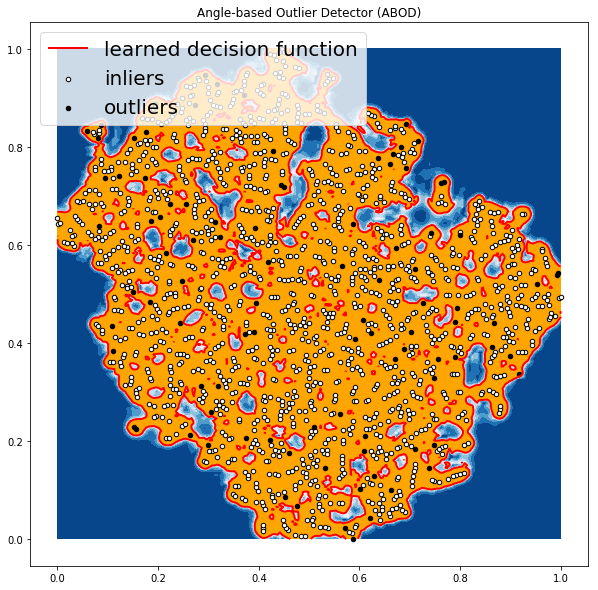

OUTLIERS :  59 INLIERS :  1434 Feature Bagging


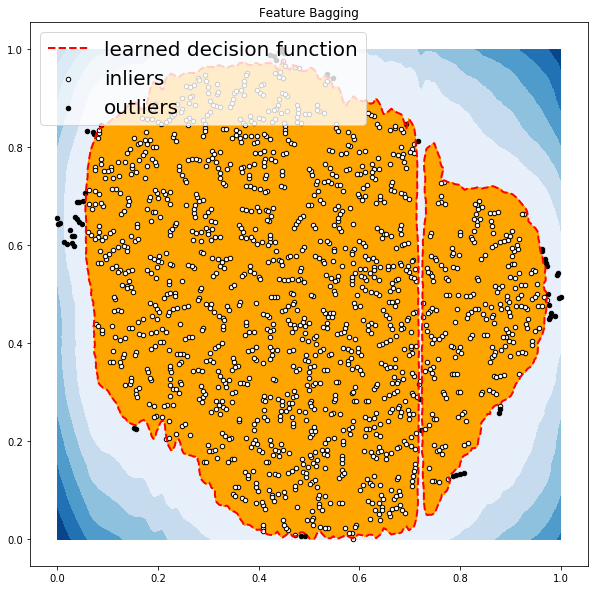

OUTLIERS :  45 INLIERS :  1448 Histogram-base Outlier Detection (HBOS)


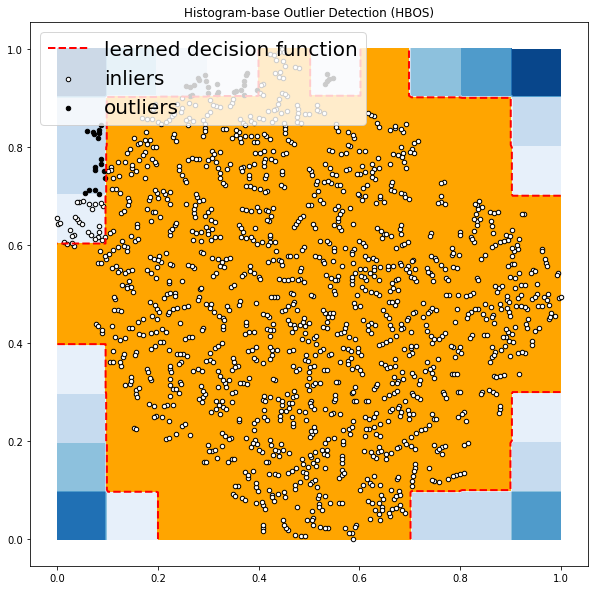

OUTLIERS :  65 INLIERS :  1428 Isolation Forest


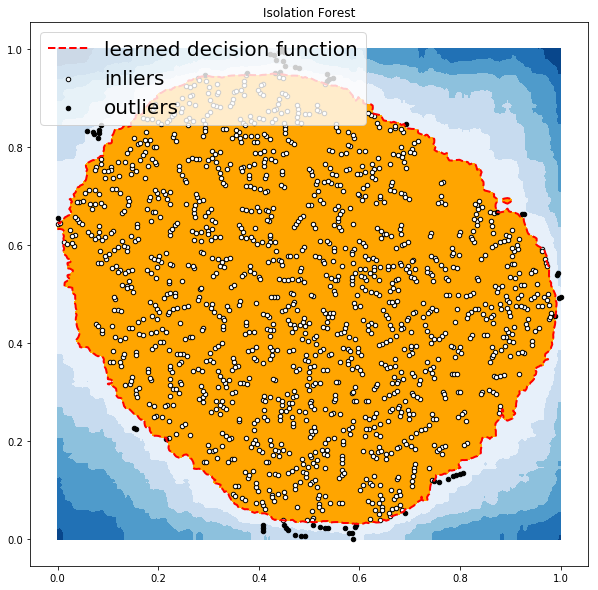

OUTLIERS :  29 INLIERS :  1464 K Nearest Neighbors (KNN)


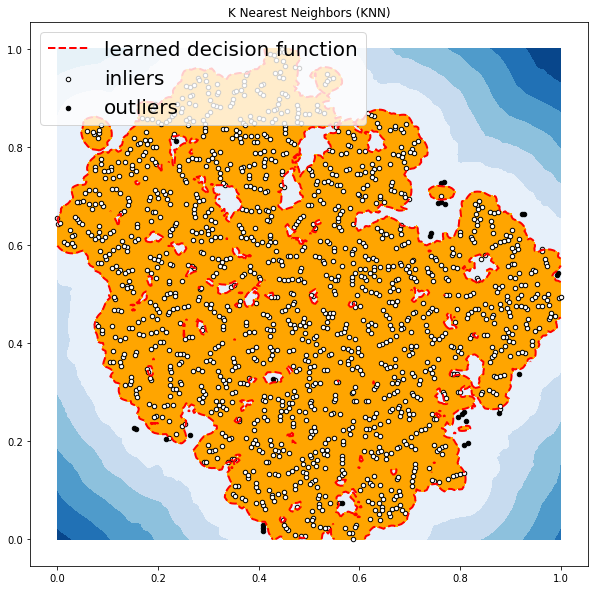

OUTLIERS :  10 INLIERS :  1483 Average KNN


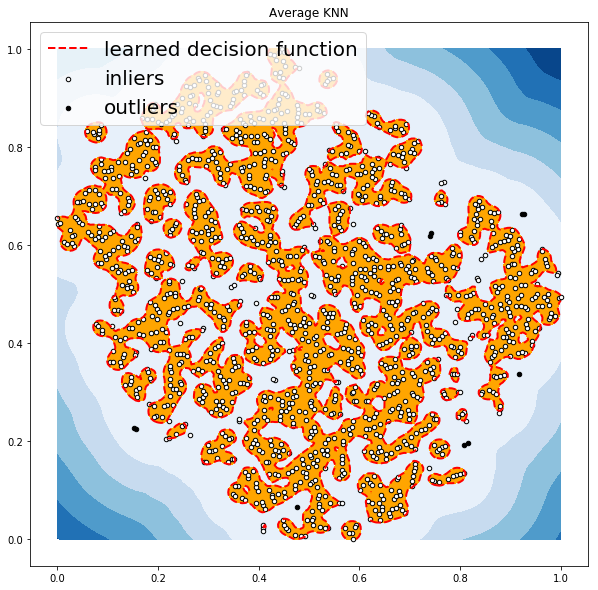

OUTLIERS :  65 INLIERS :  1428 Cluster-based Local Outlier Factor (CBLOF)


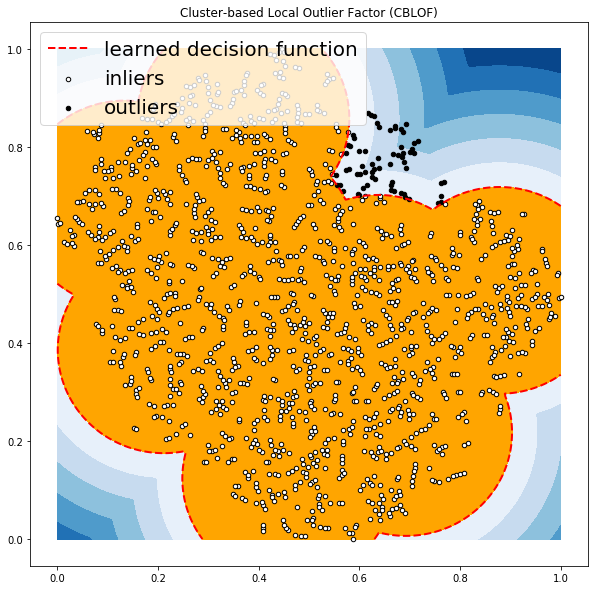

OUTLIERS :  51 INLIERS :  1442 Feature Bagging_50


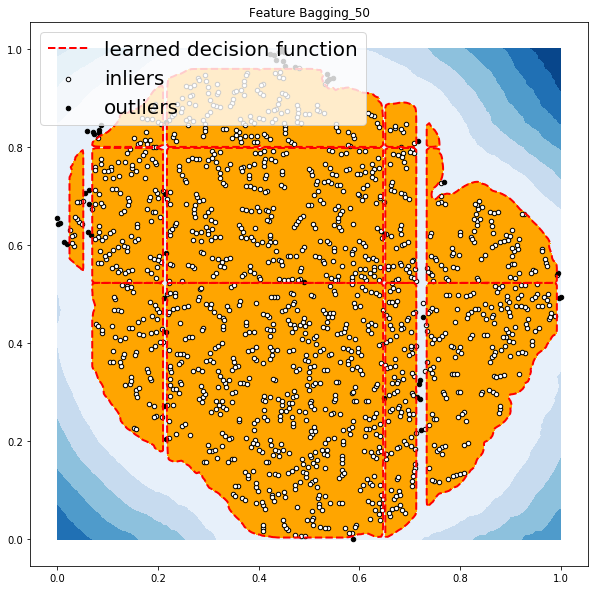

In [20]:
xx , yy = np.meshgrid(np.linspace(0,1, 200), np.linspace(0, 1, 200))

for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(df)
    # predict raw anomaly score
    scores_pred = clf.decision_function(df) * -1
        
    # prediction of a datapoint category outlier or inlier
    y_pred = clf.predict(df)
    n_inliers = len(y_pred) - np.count_nonzero(y_pred)
    n_outliers = np.count_nonzero(y_pred == 1)
    plt.figure(figsize=(10, 10))
    

    targets[clf_name] = y_pred.tolist()
    
    # IX1 - inlier feature 1,  IX2 - inlier feature 2
    IX1 =  np.array(df['X1'][targets[clf_name] == 0]).reshape(-1,1)
    IX2 =  np.array(df['X2'][targets[clf_name] == 0]).reshape(-1,1)
    
    # OX1 - outlier feature 1, OX2 - outlier feature 2
    OX1 =  df['X1'][targets[clf_name] == 1].values.reshape(-1,1)
    OX2 =  df['X2'][targets[clf_name] == 1].values.reshape(-1,1)
         
    print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        
    # threshold value to consider a datapoint inlier or outlier
    threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
    # decision function calculates the raw anomaly score for every point
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    # fill blue map colormap from minimum anomaly score to threshold value
    plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
    # draw red contour line where anomaly score is equal to thresold
    a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
    # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
        
    b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
    
    c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
       
    
    plt.legend(
        [a.collections[0], b,c],
        ['learned decision function', 'inliers','outliers'],
        prop=matplotlib.font_manager.FontProperties(size=20),
        loc=2)
      
    plt.title(clf_name)
    plt.show()